In [1]:
from PIL import Image
import pandas as pd
import numpy as np

In [2]:
# Define a function to load and process the image
def process_image(image_path):
    # Open an image file
    img = Image.open(image_path)

    # Convert image data to a numpy array
    img_data = np.array(img)

    # If the image has an alpha (transparency) channel, ignore it
    if img_data.shape[2] > 3:
        img_data = img_data[:, :, x:3]

    # Get height and width
    height, width, _ = img_data.shape

    # Create x, y coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Create a DataFrame
    df = pd.DataFrame({'x': x.flatten(), 'y': y.flatten()})

    # Add RGB values to DataFrame
    df[['r', 'g', 'b']] = pd.DataFrame(img_data.reshape(-1, 3), index=df.index)

    return df


In [3]:
# Define a function to load and process the image
def process_image(image_path):
    # Open an image file
    img = Image.open(image_path)

    # Convert image data to a numpy array
    img_data = np.array(img)

    # If the image has an alpha (transparency) channel, ignore it
    if img_data.shape[2] > 3:
        img_data = img_data[:, :, :3]

    # Get height and width
    height, width, _ = img_data.shape

    # Create x, y coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Create a DataFrame
    df = pd.DataFrame({'x': x.flatten(), 'y': y.flatten()})

    # Add RGB values to DataFrame
    df[['r', 'g', 'b']] = pd.DataFrame(img_data.reshape(-1, 3), index=df.index)

    return df, height, width



# List of image names
image_names = ['Marilyn_blue.png', 'Marilyn_green.png', 'Marilyn_orange.png', 'Marilyn_red.png', 'Marilyn_teal.png']

# List of colors
colors = ['blue', 'green', 'orange', 'red', 'teal']

# Dictionary to store each DataFrame
np_dict = {}


# Process each image and store the resulting DataFrame in the dictionary
for image_name, color in zip(image_names, colors):
    np_dict[color], height, width = process_image(image_name)

blue = np_dict['blue']
green = np_dict['green']
orange = np_dict['orange']
red = np_dict['red']
teal = np_dict['teal']


In [4]:
blue.shape

(562500, 5)

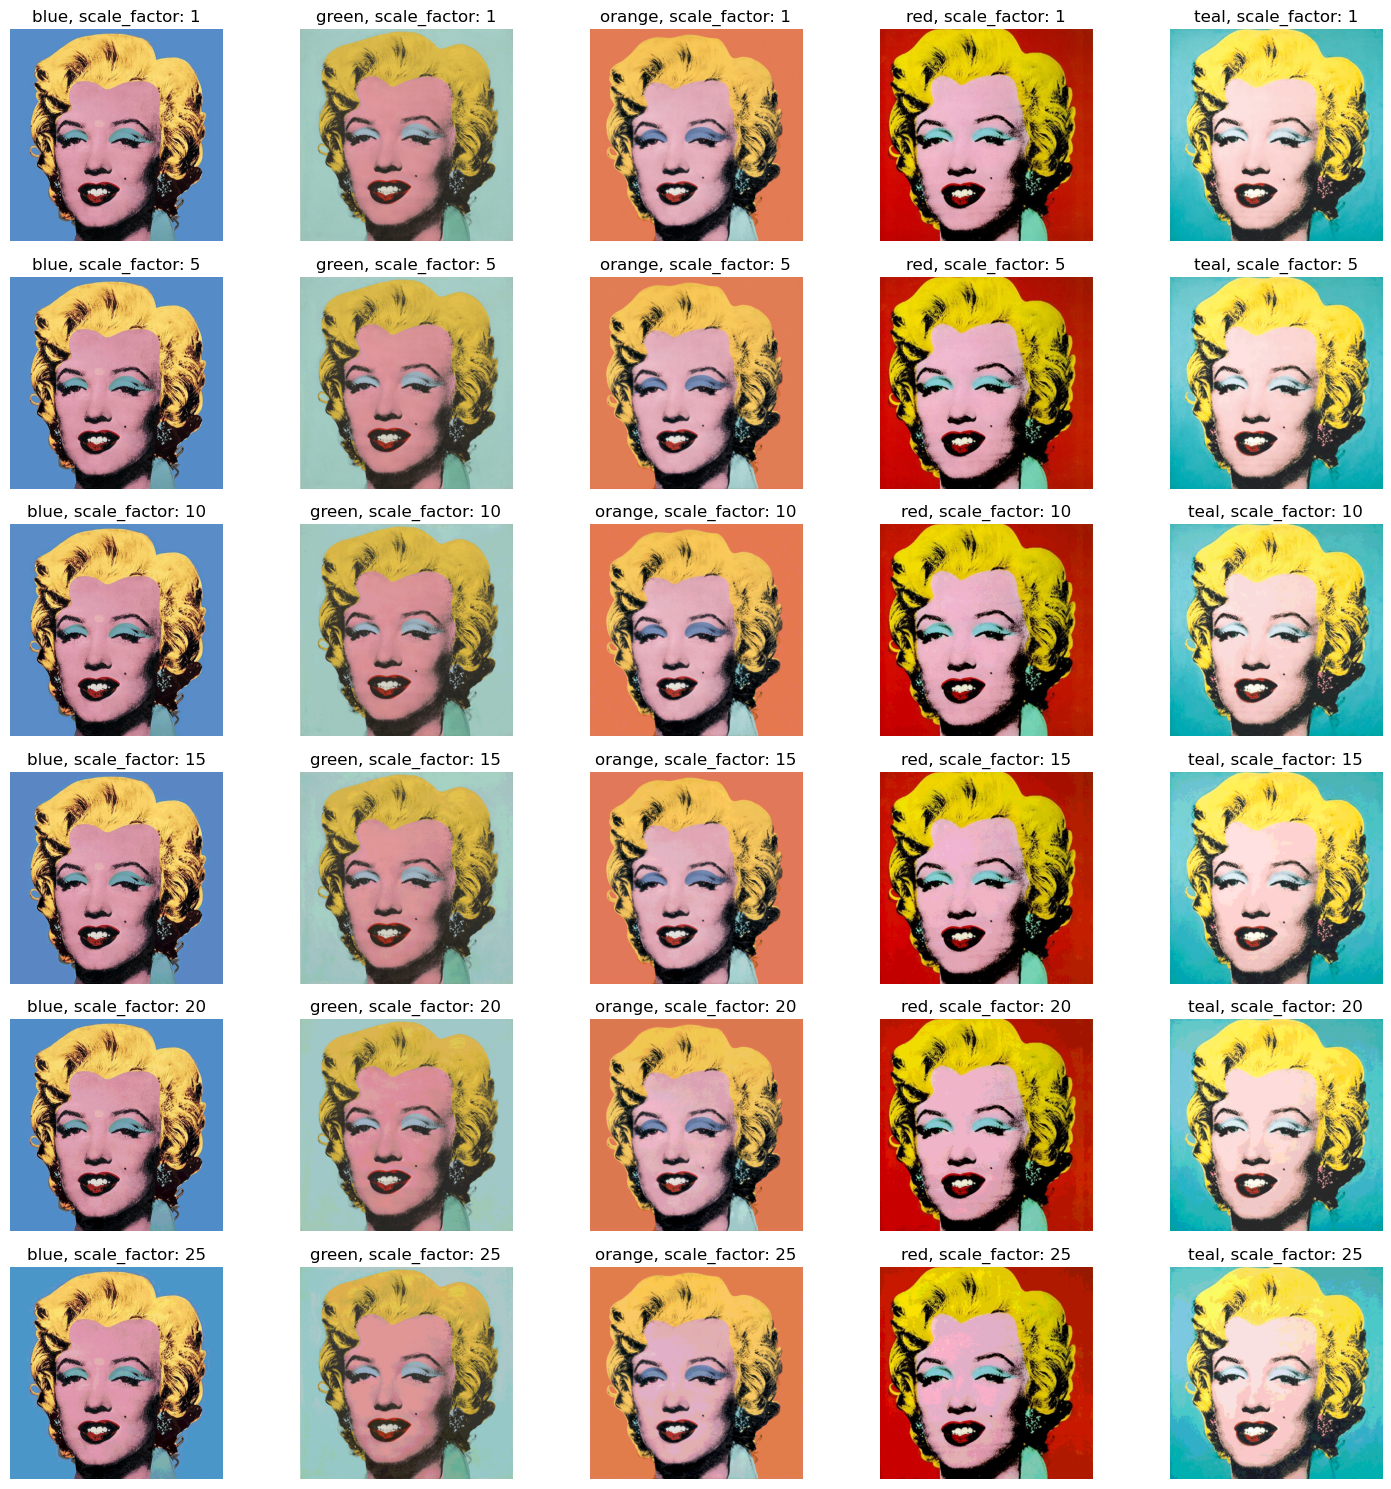

In [5]:
import matplotlib.pyplot as plt

# Define the function to reduce color depth
def reduce_color_depth(df, scale_factor):
    # Separate the color information
    rgb_array = df[['r', 'g', 'b']].to_numpy()
    
    # Reduce color depth
    reduced_rgb_array = (rgb_array / scale_factor).round() * scale_factor
    reduced_rgb_array = np.clip(reduced_rgb_array, 0, 255).astype(np.uint8)
    
    # Replace color columns in the DataFrame
    df[['r', 'g', 'b']] = reduced_rgb_array
    
    return df

# List of scale factors
scale_factors = [1,5,10, 15, 20, 25]

# Initialize a figure
fig, ax = plt.subplots(len(scale_factors), len(np_dict), figsize=(15, 15))


for i, scale_factor in enumerate(scale_factors):
    for j, (color, df) in enumerate(np_dict.items()):
        # Reduce color depth
        reduced_df = reduce_color_depth(df.copy(), scale_factor)
        
        # Convert DataFrame back to image array for visualization
        reduced_img_array = reduced_df[['r', 'g', 'b']].to_numpy().reshape(height, width, 3)
        
        # Plot
        ax[i, j].imshow(reduced_img_array)
        ax[i, j].set_title(f'{color}, scale_factor: {scale_factor}')
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()


In [6]:
import io
from PIL import Image

def get_image_size(df, height, width):
    # Create a BytesIO object
    output = io.BytesIO()

    # Convert DataFrame back to image array
    img_array = df[['r', 'g', 'b']].to_numpy().reshape(height, width, 3)

    # Create an Image object from the array
    img = Image.fromarray(img_array.astype('uint8'))

    # Save the Image object to the BytesIO object as a PNG
    img.save(output, format='PNG')

    # Get the size of the BytesIO object
    size = output.tell()

    return size
import sys

# Apply the color depth reduction
scale_factor = 10
reduced_dict = {color: reduce_color_depth(df.copy(), scale_factor) for color, df in np_dict.items()}


# Print the size of the original and reduced images
for color in np_dict:
    original_size = get_image_size(np_dict[color], height, width)
    reduced_size = get_image_size(reduced_dict[color], height, width)
    print(f'Color: {color}')
    print(f'Original image size: {original_size} bytes')
    print(f'Reduced image size: {reduced_size} bytes')
    print(f'Saved space: {original_size - reduced_size} bytes\n')


Color: blue
Original image size: 731332 bytes
Reduced image size: 378675 bytes
Saved space: 352657 bytes

Color: green
Original image size: 916583 bytes
Reduced image size: 365305 bytes
Saved space: 551278 bytes

Color: orange
Original image size: 663328 bytes
Reduced image size: 311998 bytes
Saved space: 351330 bytes

Color: red
Original image size: 700900 bytes
Reduced image size: 284432 bytes
Saved space: 416468 bytes

Color: teal
Original image size: 674124 bytes
Reduced image size: 281088 bytes
Saved space: 393036 bytes



# Color composition 

## Main colors with KMeans

In [7]:
from sklearn.cluster import KMeans

def quantify_colors(df, n_colors):
    # Perform k-means clustering to find the most common colors
    kmeans = KMeans(n_clusters=n_colors)
    labels = kmeans.fit_predict(df[['r', 'g', 'b']])

    # Count how many pixels belong to each cluster
    unique, counts = np.unique(labels, return_counts=True)

    # Store the count and color of each cluster
    cluster_info = {label: {'count': count, 'color': kmeans.cluster_centers_[label]} for label, count in zip(unique, counts)}

    return cluster_info

# Calculate color frequencies for each image
n_colors = 5
color_infos = {color: quantify_colors(df, n_colors) for color, df in np_dict.items()}


fig, axes = plt.subplots(len(np_dict), 2, figsize=(15, len(np_dict)*5))  # Create a grid of subplots

for i, (color, df) in enumerate(np_dict.items()):
    # Plot the original image on the left
    img_array = df[['r', 'g', 'b']].to_numpy().reshape(height, width, 3)
    axes[i, 0].imshow(img_array)
    axes[i, 0].axis('off')

    # Get color information for this image
    info = color_infos[color]
    
    # Plot the pie chart on the right
    labels, data = zip(*[(label, d['count']) for label, d in info.items()])
    colors = [d['color']/255 for d in info.values()]  # Divide by 255 to convert RGB values to [0, 1] range
    patches, texts, autotexts = axes[i, 1].pie(data, labels=labels, colors=colors, autopct='%1.1f%%')

    # Add a legend with RGB values
    legend_labels = [f'{label}: {str(np.round(info[label]["color"], 1))}' for label in labels]
    axes[i, 1].legend(patches, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    axes[i, 1].set_title(color)

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

## Attempt at Hierarchical clustering but failed due to insufficient memory. 
We tried several methods to solve the insufficient memory problem: 
- Separated face from the rest image and turnd the backgroud to transparent
- reduced color depth and filter out any transparent pixel 


In [ ]:
import numpy as np
from PIL import Image
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Load the image
img = Image.open('blue_face.png')

# Convert the image to a NumPy array
img_array = np.array(img)

# Get the dimensions of the image
height, width, _ = img_array.shape

# Define a function to reduce color depth
def reduce_color_depth(img_array, scale_factor):
    return (img_array / scale_factor).astype(int) * scale_factor

# Apply the color depth reduction
img_array_reduced = reduce_color_depth(img_array, scale_factor=10)

# Reshape the image to be a 2D array of 5D vectors (x, y, r, g, b)
pixels = np.zeros((width * height, 5))
for x in range(width):
    for y in range(height):
        rgba = img_array_reduced[x, y, :]
        pixels[x * height + y, :] = x, y, rgba[0], rgba[1], rgba[2]

# Filter out the transparent pixels
pixels = pixels[pixels[:,2:5].sum(axis=1) > 0]

# Normalize the features
pixels_normalized = pixels / pixels.max(axis=0)

# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=5).fit(pixels_normalized)

# Reshape the labels from the clustering to be the same shape as the original image
labels = clustering.labels_.reshape((width, height))

# Display the clustering result
plt.imshow(labels)
plt.show()


: 

: 

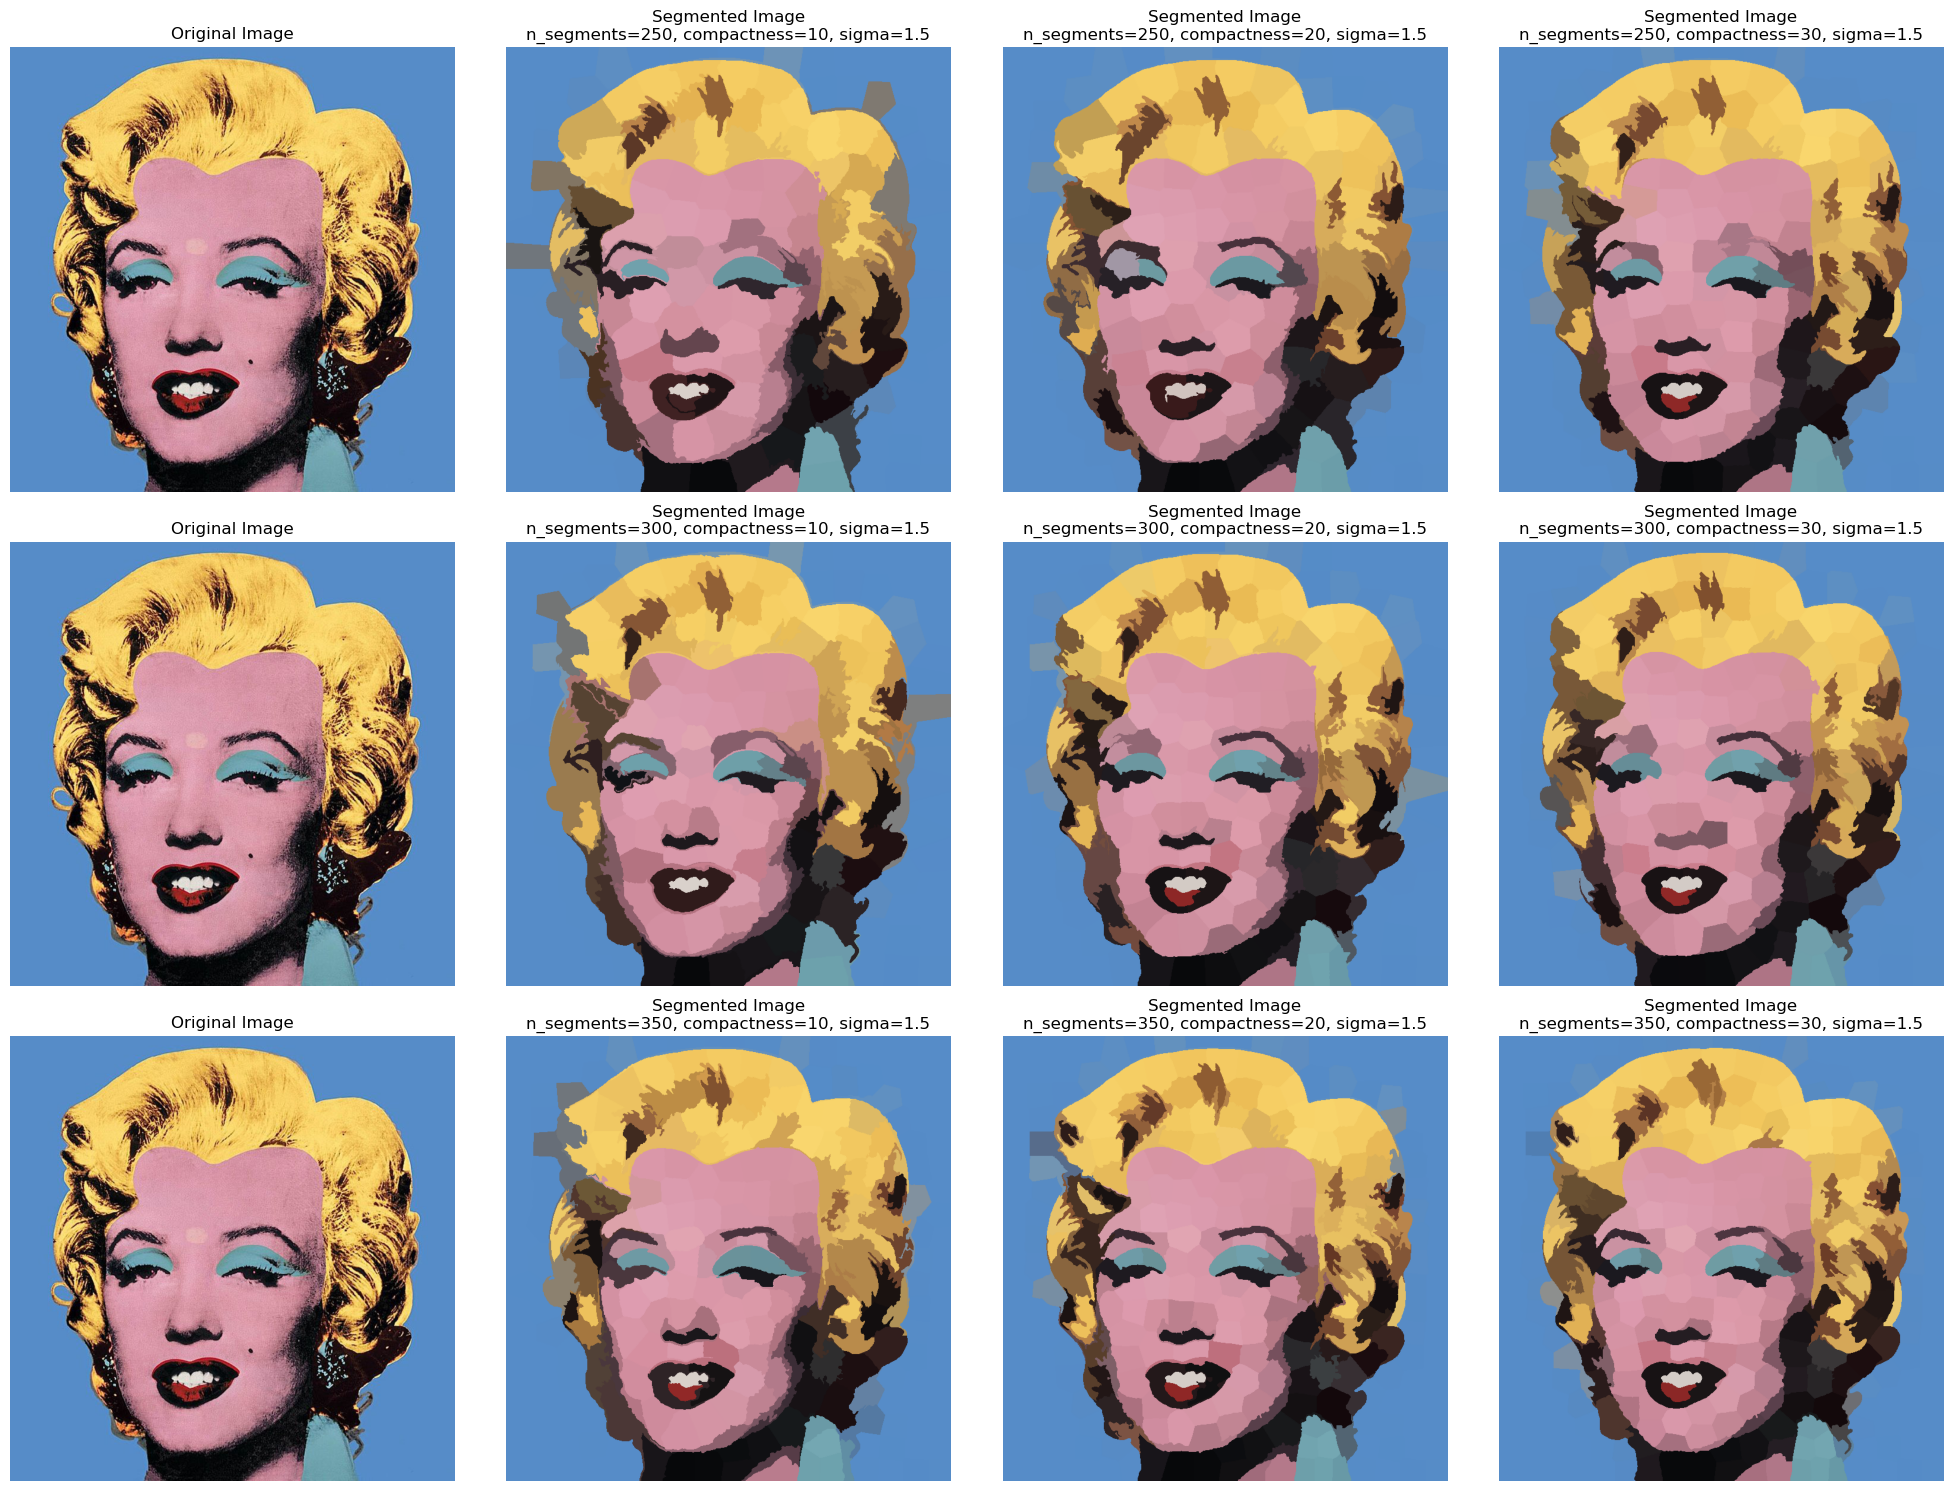

In [ ]:
# Define the parameter values to test
n_segments_values = [250, 300,350]
compactness_values = [10, 20, 30]
sigma_values = [0.5, 1, 1.5]

# Create a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharex=True, sharey=True)

# Loop over the parameter values
for i, n_segments in enumerate(n_segments_values):
    for j, compactness in enumerate(compactness_values):
        for k, sigma in enumerate(sigma_values):
            # Apply SLIC with the current parameter values
            segments = slic(image, n_segments=n_segments, compactness=compactness, sigma=sigma)
            
            # Plot the original image and the segmented image
            if j == 0 and k == 0:
                axes[i][0].imshow(image)
                axes[i][0].set_title('Original Image')
            
            axes[i][j+1].imshow(label2rgb(segments, image, kind='avg'))
            axes[i][j+1].set_title(f'Segmented Image\nn_segments={n_segments}, compactness={compactness}, sigma={sigma}')

# Remove axis labels
for ax in axes.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()


In [24]:
image

array([[[148, 181, 169, 255],
        [151, 185, 173, 255],
        [150, 185, 173, 255],
        ...,
        [154, 190, 179, 255],
        [155, 191, 180, 255],
        [156, 190, 178, 255]],

       [[150, 186, 175, 255],
        [157, 190, 179, 255],
        [150, 186, 174, 255],
        ...,
        [154, 188, 178, 255],
        [156, 189, 179, 255],
        [154, 189, 176, 255]],

       [[156, 190, 179, 255],
        [159, 194, 183, 255],
        [158, 193, 181, 255],
        ...,
        [155, 191, 179, 255],
        [155, 189, 178, 255],
        [152, 186, 175, 255]],

       ...,

       [[247, 249, 248, 255],
        [169, 197, 187, 255],
        [153, 191, 178, 255],
        ...,
        [159, 192, 181, 255],
        [161, 194, 183, 255],
        [159, 194, 182, 255]],

       [[247, 249, 248, 255],
        [168, 195, 186, 255],
        [150, 188, 176, 255],
        ...,
        [155, 188, 177, 255],
        [157, 191, 180, 255],
        [157, 191, 179, 255]],

       [[248

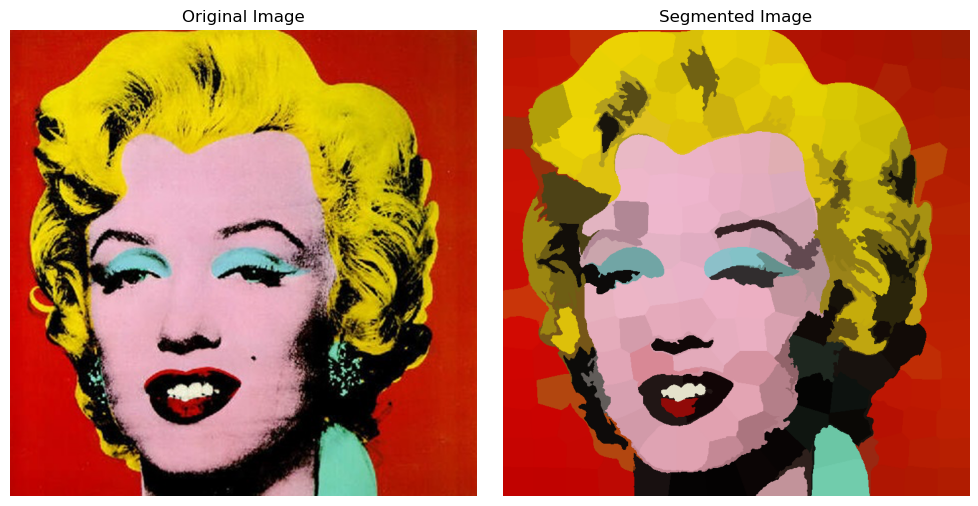

In [29]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.segmentation import slic
from skimage.color import label2rgb

# Load the image
image = imread('Marilyn_red.png')

# Check if the image has an alpha channel (transparency information)
if image.shape[2] == 4:
    # If the image has an alpha channel, discard it
    image = image[:, :, :3]

# Apply SLIC and extract (approximately) the number of superpixels
segments = slic(image, n_segments=250, compactness=20, sigma=1.5)

# Visualize the superpixels
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
                        sharex=True, sharey=True)

ax[0].imshow(image)
ax[0].set_title('Original Image')

ax[1].imshow(label2rgb(segments, image, kind='avg'))
ax[1].set_title('Segmented Image')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()
plt.show()


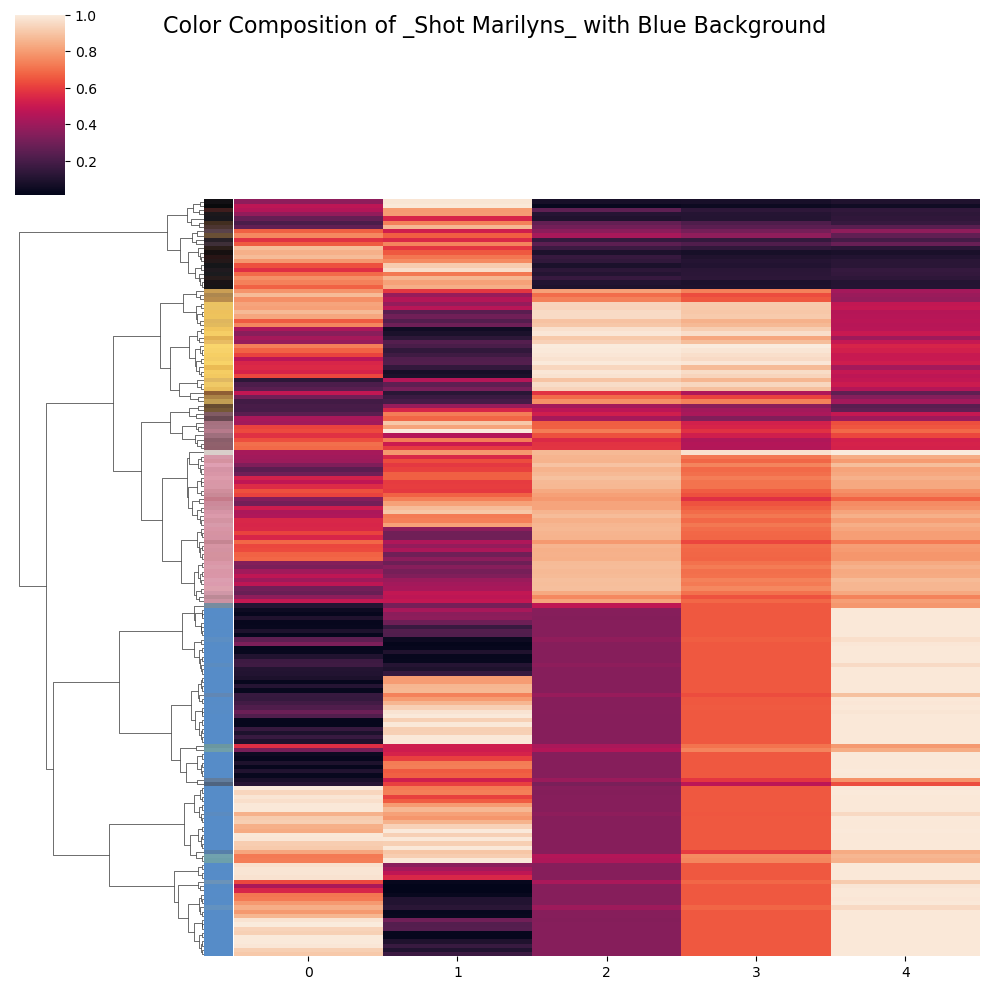

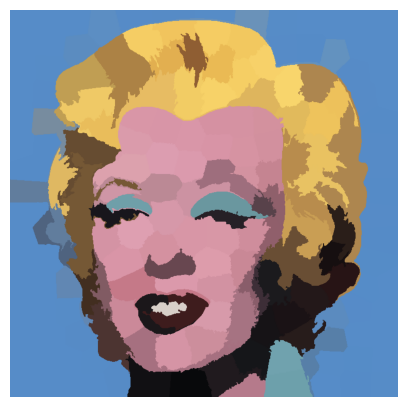

In [17]:
from skimage.segmentation import slic
from scipy.cluster.hierarchy import linkage
import seaborn as sns
from scipy.cluster.hierarchy import leaves_list
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Load the image
img = Image.open('Marilyn_blue.png')

# Convert the image to a NumPy array
img_array = np.array(img)

# Get the dimensions of the image
height, width, _ = img_array.shape

# Apply SLIC to get superpixels
superpixels = slic(img_array, n_segments=250, compactness=10, sigma=1)

# Get the unique superpixel labels
unique_superpixels = np.unique(superpixels)

# Initialize an empty list to hold the feature vectors
features = []

# Initialize an empty array to hold the superpixel image
superpixel_img = np.zeros_like(img_array)

# Loop over the unique superpixel labels
for superpixel in unique_superpixels:
    # Get the pixels for this superpixel
    superpixel_pixels = img_array[superpixels == superpixel]
    
    # Calculate the average color for this superpixel
    avg_color = superpixel_pixels.mean(axis=0)
    
    # Replace the colors in the superpixel with the average color
    superpixel_img[superpixels == superpixel] = avg_color
    
    # Calculate the centroid coordinates for this superpixel
    y, x = np.argwhere(superpixels == superpixel).mean(axis=0)
    
    # Append the features to the list
    features.append(np.concatenate([[x, y], avg_color]))

# Convert the list of features into a NumPy array
features = np.array(features)

# Normalize the features
features_normalized = features / features.max(axis=0)

# Perform hierarchical clustering
Z = linkage(features_normalized, 'ward')

# Create a dendrogram
g = sns.clustermap(features_normalized, method='ward', col_cluster=False, row_colors=features[:,2:5]/255, yticklabels=False)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # Rotate the y-axis labels
g.fig.suptitle('Color Composition of Shot Marilyns with Blue Background', fontsize=16)  # Add a title to the figure

# Display the superpixel image in a new figure
plt.figure(figsize=(5, 10))
plt.imshow(superpixel_img)
plt.axis('off')  # Hide the axis labels
plt.show()


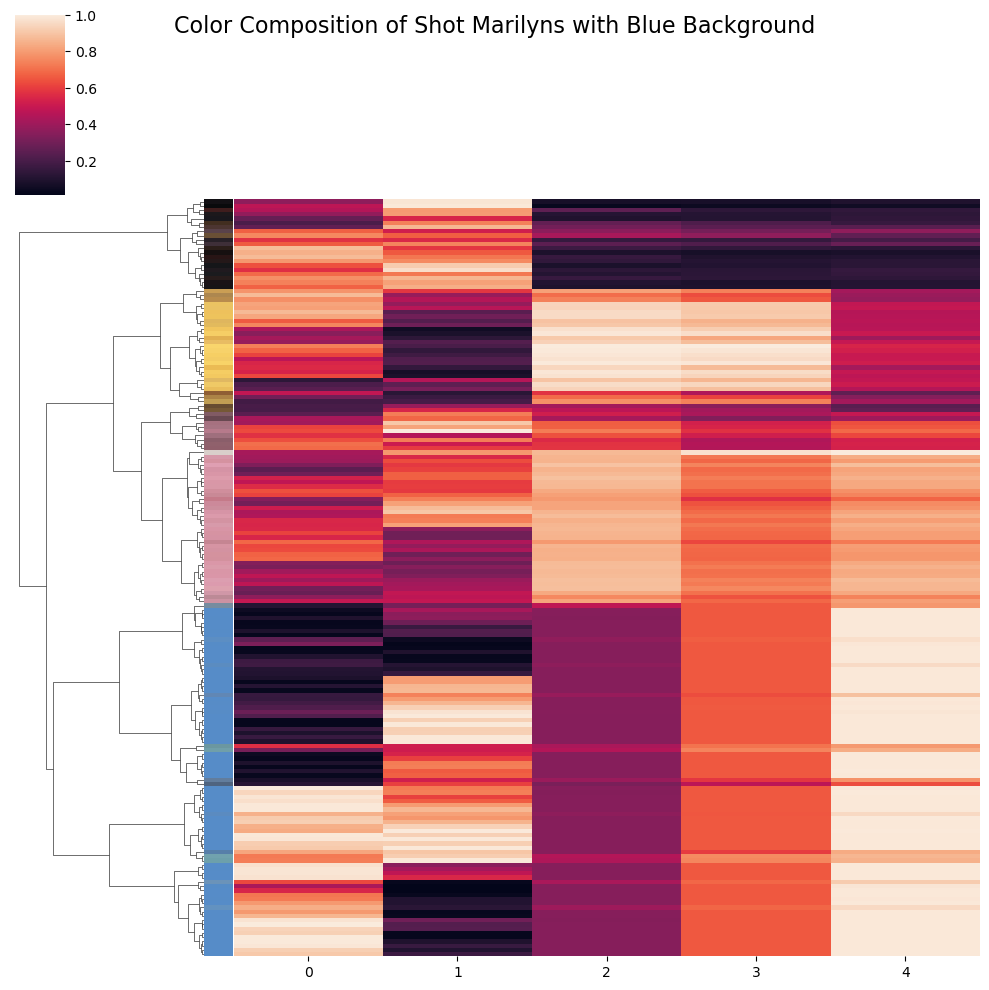

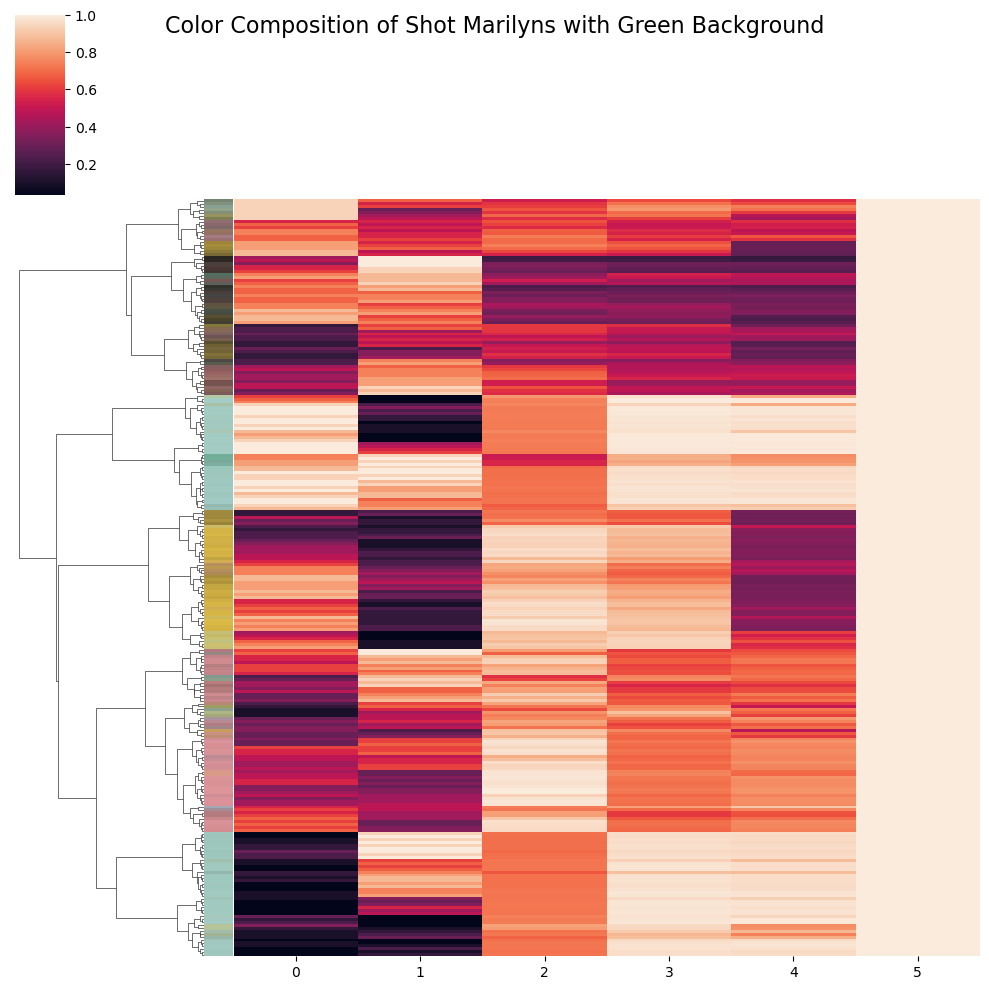

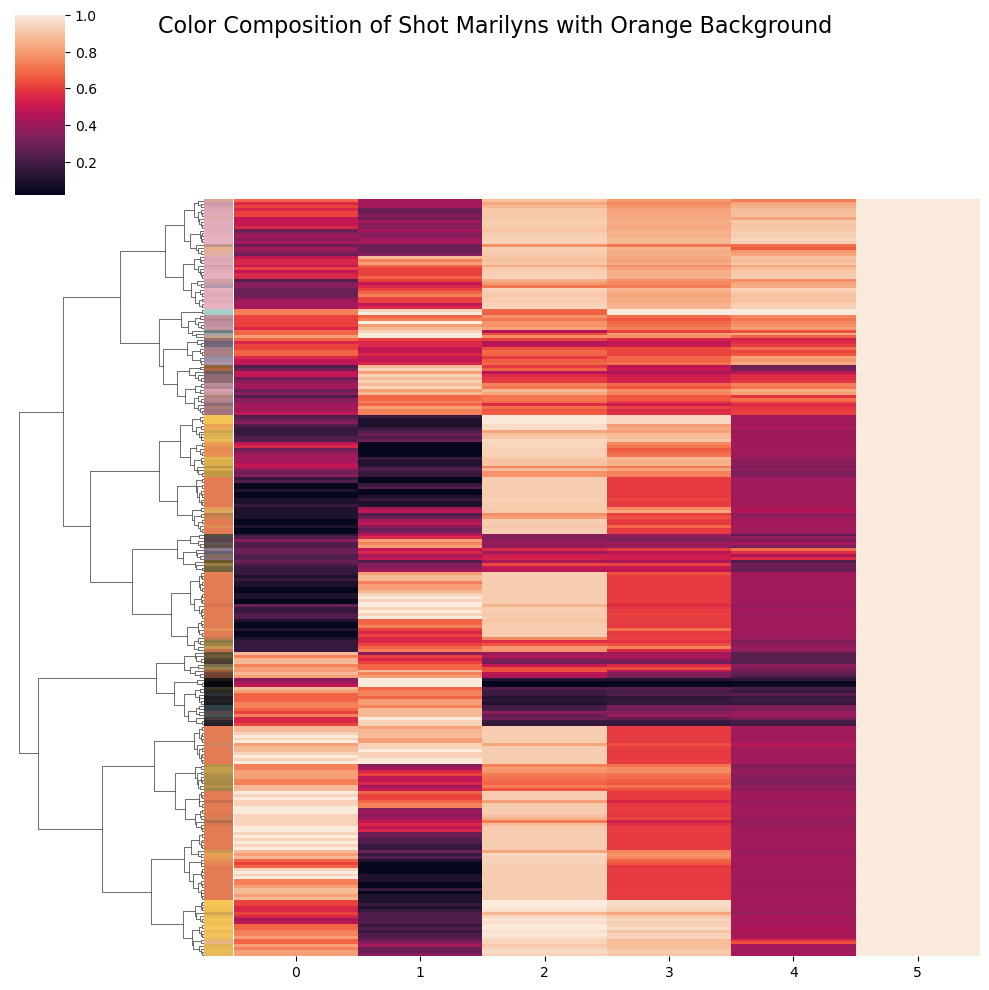

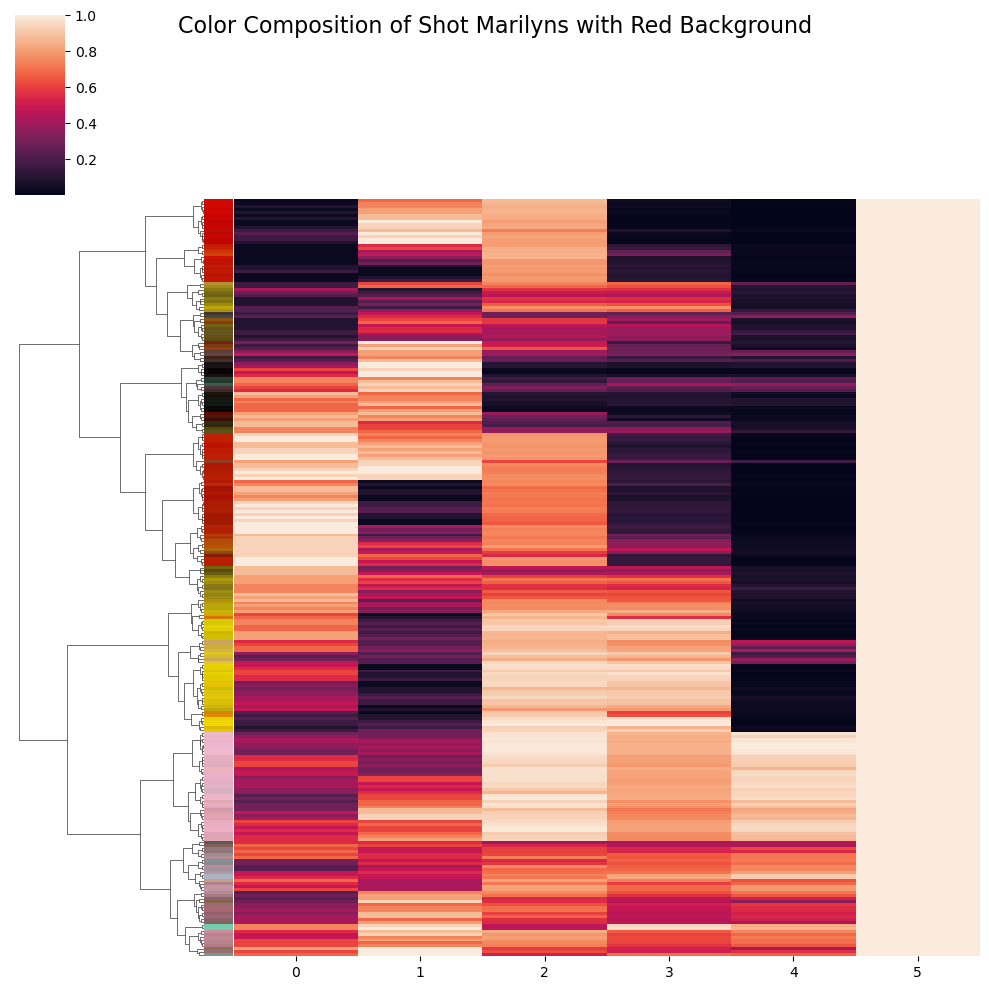

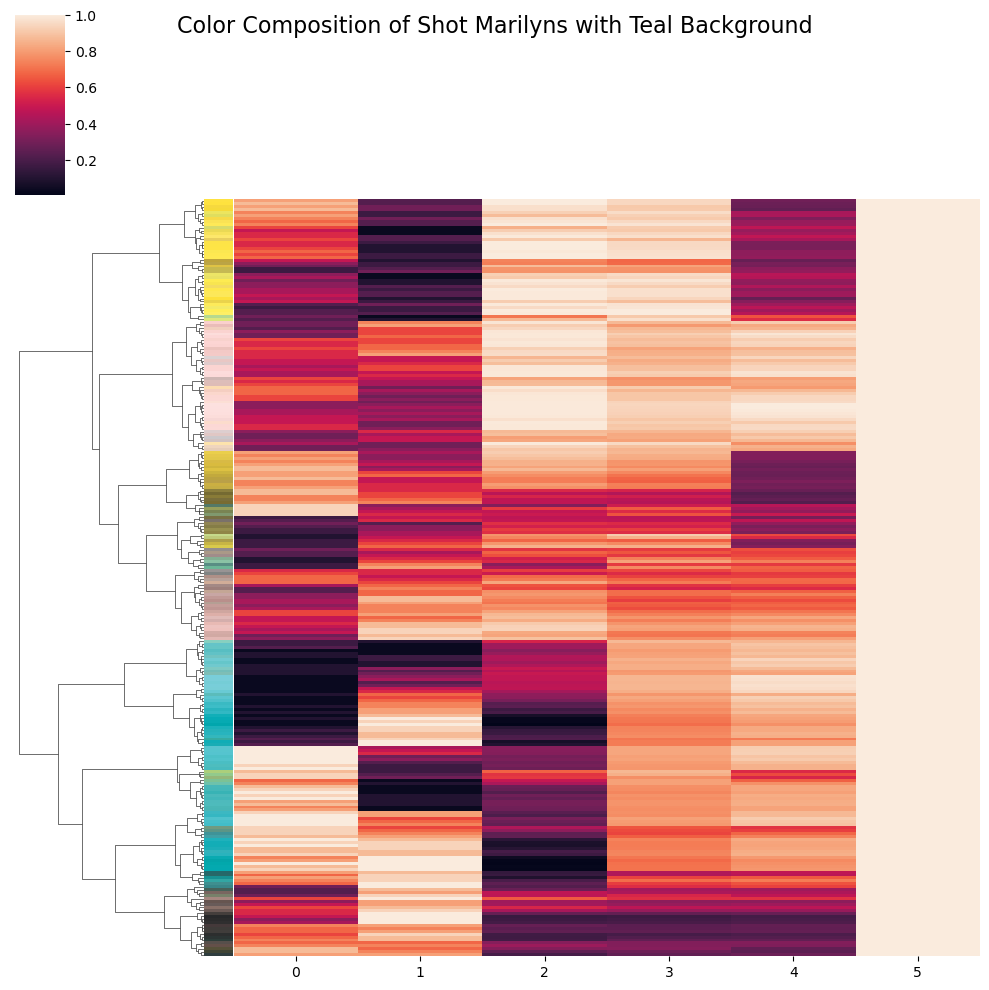

In [26]:
from skimage.segmentation import slic
from scipy.cluster.hierarchy import linkage
import seaborn as sns
from scipy.cluster.hierarchy import leaves_list
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# List of image names
image_names = ['Marilyn_blue.png', 'Marilyn_green.png', 'Marilyn_orange.png', 'Marilyn_red.png', 'Marilyn_teal.png']

# Loop over each image
for image_name in image_names:
    # Load the image
    img = Image.open(image_name)

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Get the dimensions of the image
    height, width, _ = img_array.shape

    # Apply SLIC to get superpixels
    superpixels = slic(img_array, n_segments=250, compactness=10, sigma=1)

    # Get the unique superpixel labels
    unique_superpixels = np.unique(superpixels)

    # Initialize an empty list to hold the feature vectors
    features = []

    # Initialize an empty array to hold the superpixel image
    superpixel_img = np.zeros_like(img_array)

    # Loop over the unique superpixel labels
    for superpixel in unique_superpixels:
        # Get the pixels for this superpixel
        superpixel_pixels = img_array[superpixels == superpixel]
        
        # Calculate the average color for this superpixel
        avg_color = superpixel_pixels.mean(axis=0)
        
        # Replace the colors in the superpixel with the average color
        superpixel_img[superpixels == superpixel] = avg_color
        
        # Calculate the centroid coordinates for this superpixel
        y, x = np.argwhere(superpixels == superpixel).mean(axis=0)
        
        # Append the features to the list
        features.append(np.concatenate([[x, y], avg_color]))

    # Convert the list of features into a NumPy array
    features = np.array(features)

    # Normalize the features
    features_normalized = features / features.max(axis=0)

    # Perform hierarchical clustering
    Z = linkage(features_normalized, 'ward')

    # Create a dendrogram
    g = sns.clustermap(features_normalized, method='ward', col_cluster=False, row_colors=features[:,2:5]/255, yticklabels=False)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # Rotate the y-axis labels
    g.fig.suptitle(f'Color Composition of Shot Marilyns with {image_name.split("_")[1].split(".")[0].capitalize()} Background', fontsize=16)  # Add a title to the figure

    # Display the figure
    plt.show()

